# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [2]:
# installation of sklearn_crfsuite
# !pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [3]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [146]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [5]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [6]:
# define a function to load json file to a dataframe
def loadJsonData(filePath):
    """
    Load JSON data from a file and convert it to a pandas DataFrame.
    
    Args:
        filePath (str): The path to the JSON file.
        
    Returns:
        pd.DataFrame: DataFrame containing the loaded JSON data.
    """
    with open(filePath, 'r') as file:
        data = json.load(file)
    return pd.DataFrame(data)

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [7]:
# read the json file by giving the file path and create a dataframe
inputDF = loadJsonData('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [8]:
# display first five rows of the dataframe - df
inputDF.head(5)

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [9]:
# print the dimensions of dataframe - df
inputDF.shape

(285, 2)

In [10]:
# print the information of the dataframe
inputDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [27]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
nlpModel = spacy.load("en_core_web_sm")
# Tokenize input
inputDF['input_tokens'] = inputDF['input'].apply(lambda x: [token.text for token in nlpModel(x)])
# Tokenize POS
inputDF['pos_tokens'] = inputDF['pos'].apply(lambda x: [token.text for token in nlpModel(x)])

In [28]:
# display first five rows of the dataframe - df
inputDF.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_check_flag
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",31,31,True
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2, -, 1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1, -, 1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",34,34,True
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1, -, 1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",37,37,True
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quant

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [29]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
inputDF['input_length'] = inputDF['input_tokens'].apply(lambda x: len(x))
inputDF['pos_length'] = inputDF['pos_tokens'].apply(lambda x: len(x))

In [30]:
# check for the equality of input_length and pos_length in the dataframe
inputDF['length_check_flag'] = inputDF['input_length'] == inputDF['pos_length']

In [38]:
inputDF['length_check_flag'].value_counts()

length_check_flag
True     204
False     81
Name: count, dtype: int64

In [32]:
inputDF[inputDF['length_check_flag'] == False].head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_check_flag
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2, -, 1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1, -, 1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",38,34,False
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1, -, 1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]",39,37,False
13,600 grams Aar Maach rohu katla 1 Tomato 2 Bay leaves 1-1/2 tablespoons Ginger paste 4 Green Chillies teaspoon Cumin powder Coriander Powder Salt 1/2 seeds Turmeric slit lengthwise 1-1/4 cups Water Sugar tablespoon Leaves,quantity unit ingredient ingredient ingredient ingredient quantity ingredient quantity ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient,"[600, grams, Aar, Maach, rohu, katla, 1, Tomato, 2, Bay, leaves, 1, -, 1/2, tablespoons, Ginger, paste, 4, Green, Chillies, teaspoon, Cumin, powder, Coriander, Powder, Salt, 1/2, seeds, Turmeric, slit, lengthwise, 1, -, 1/4, cups, Water, Sugar, tablespoon, Leaves]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient]",39,35,False
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[2, cups, curd

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [33]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def uniqueLabels(df):
    """
    Extracts and prints unique POS labels from the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing POS labels.
    """
    posLabels = set()
    for pos in df['pos_tokens']:
        posLabels.update(pos)
    
    print("Unique POS labels in the recipe:")
    print(posLabels)

In [46]:
uniqueLabels(inputDF)

Unique POS labels in the recipe:
{'unit', 'ingredient', 'quantity'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


In [47]:
inputDF[inputDF['length_check_flag'] == False].index

Index([  1,   2,  13,  17,  23,  27,  33,  37,  42,  46,  48,  58,  60,  63,
        65,  69,  71,  73,  74,  77,  79,  82,  84,  86,  87,  94, 100, 107,
       110, 111, 112, 114, 121, 130, 133, 146, 147, 150, 152, 154, 156, 157,
       158, 159, 163, 164, 168, 173, 176, 183, 185, 188, 190, 192, 196, 203,
       204, 205, 207, 216, 218, 219, 221, 222, 226, 228, 234, 239, 241, 242,
       243, 244, 245, 247, 250, 251, 258, 261, 265, 268, 277],
      dtype='int64')

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [48]:
# drop the irrelevant recipe data
df = inputDF[inputDF['length_check_flag'] == True].reset_index(drop=True)

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [49]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(lambda x: len(x))
df['pos_length'] = df['pos_tokens'].apply(lambda x: len(x))

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [50]:
# validate the input length and pos length as input_length and pos_length
df['length_check_flag'] = df['input_length'] == df['pos_length']
df['length_check_flag'].value_counts()

length_check_flag
True    204
Name: count, dtype: int64

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [53]:
# split the dataset into training and validation sets
trainDF, valDF = train_test_split(df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [54]:
# print the first five rows of train_df
trainDF.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_check_flag
98,1 cup Gram flour besan 1/2 teaspoon Ajwain Carom seeds 1/4 Red Chilli powder 2 tablespoons Curd Dahi Yogurt Sunflower Oil Green Bell Pepper Capsicum Cumin Asafoetida hing Turmeric Garam masala Amchur Dry Mango Powder Coriander Dhania 4 sprig Leaves chopped,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient,"[1, cup, Gram, flour, besan, 1/2, teaspoon, Ajwain, Carom, seeds, 1/4, Red, Chilli, powder, 2, tablespoons, Curd, Dahi, Yogurt, Sunflower, Oil, Green, Bell, Pepper, Capsicum, Cumin, Asafoetida, hing, Turmeric, Garam, masala, Amchur, Dry, Mango, Powder, Coriander, Dhania, 4, sprig, Leaves, chopped]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",41,41,True
31,1 eggplant 2 inch ginger onion tomato green chillies teaspoon turmeric powder garam masala coriander tablespoon butter red chili oil sprigs of,quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient unit ingredient,"[1, eggplant, 2, inch, ginger, onion, tomato, green, chillies, teaspoon, turmeric, powder, garam, masala, coriander, tablespoon, butter, red, chili, oil, sprigs, of]","[quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient]",22,22,True
12,2 onions 1 teaspoon cumin seeds tablespoons black urad dal split tamarind paste 3 dry red chillies 1/2 jaggery teaspoons oil salt sprig curry leaves,quantity ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient unit ingredient ingredient unit ingredient ingredient,"[2, onions, 1, teaspoon, cumin, seeds, tablespoons, black, urad, dal, split, tamarind, paste, 3, dry, red, chillies, 1/2, jaggery, teaspoons, oil, salt, sprig, curry, leaves]","[quantity, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient]",25,25,True
35,2 cups Makki Ka Atta Yellow Corn Meal Flour 1 1/2 Methi Leaves Fenugreek chopped Green Chillies tablespoon Ajwain Carom seeds Kashmiri Red Chilli Powder Salt,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity quantity ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[2, cups, Makki, Ka, Atta, Yellow, Corn, Meal, Flour, 1, 1/2, Methi, Leaves, Fenugreek, chopped, Green, Chillies, tablespoon, Ajwain, Carom, seeds, Kashmiri, Red, Chilli, Powder, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, i

In [56]:
# print the first five rows of the val_df
valDF.head(5)

,input,pos,input_tokens,pos_tokens,input_length,pos_length,length_check_flag
15,1 cup rice 12 small onions 2 cloves garlic inch ginger green chillies bay leaf tsp red chilli powder turmeric carrot beans potatoes ghee cinnamon fennel whole pepper coriander seeds 1/4 peas mint leaves,quantity unit ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[1, cup, rice, 12, small, onions, 2, cloves, garlic, inch, ginger, green, chillies, bay, leaf, tsp, red, chilli, powder, turmeric, carrot, beans, potatoes, ghee, cinnamon, fennel, whole, pepper, coriander, seeds, 1/4, peas, mint, leaves]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]",34,34,True
9,2 Burger buns 5 Pickled Jalapenos sliced Cheese Slices Potatoes Aloo pressure cooked 1 Onion chopped tablespoon Red Chilli powder Salt Whole Egg 1/2 cup Wheat Bread crumbs 4 cloves Garlic Onions Tomatoes Homemade tomato puree Green Bell Pepper Capsicum Soy granules teaspoon flakes Cumin Jeera Dried oregano Tabasco Original Hot Sauce Honey Sunflower Oil,quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[2, Burger, buns, 5, Pickled, Jalapenos, sliced, Cheese, Slices, Potatoes, Aloo, pressure, cooked, 1, Onion, chopped, tablespoon, Red, Chilli, powder, Salt, Whole, Egg, 1/2, cup, Wheat, Bread, crumbs, 4, cloves, Garlic, Onions, Tomatoes, Homemade, tomato, puree, Green, Bell, Pepper, Capsicum, Soy, granules, teaspoon, flakes, Cumin, Jeera, Dried, oregano, Tabasco, Original, Hot, Sauce, Honey, Sunflower, Oil]","[quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",55,55,True
115,1/4 cup Rice Yellow Moong Dal 1 Carrot Gajjar 3 Green beans French Beans teaspoon Ghee Cumin seeds Asafoetida hing Salt a pinch,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit,"[1/4, cup, Rice, Yellow, Moong, Dal, 1, Carrot, Gajjar, 3, Green, beans, French, Beans, teaspoon, Ghee, Cumin, seeds, Asafoetida, hing, Salt, a, pinch]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit]",23,23,True

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [68]:
# extract the training and validation sets by taking input_tokens and pos_tokens
XTrain = trainDF['input_tokens']
XVal = valDF['input_tokens']
yTrain = trainDF['pos_tokens']
yVal = valDF['pos_tokens']

In [69]:
# validate the shape of training and validation samples
print("Training and Validation Set Shapes:")
print("XTrain:", XTrain.shape)
print("XVal:", XVal.shape)
print("yTrain:", YTrain.shape)
print("yVal:", YVal.shape)

Training and Validation Set Shapes:
XTrain: (142,)
XVal: (62,)
yTrain: (142,)
yVal: (62,)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [70]:
# Display the number of unique labels present in y_train
yTrain.explode().unique()

array(['quantity', 'unit', 'ingredient'], dtype=object)

## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [71]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flattenList(nestedList):
    """
    Flattens a nested list.
    
    Args:
        nestedList (list): A list that may contain other lists.
        
    Returns:
        list: A flattened version of the input list.
    """
    return [item for sublist in nestedList for item in sublist]

In [72]:
# initialise the dataset_name
dataset_name = 'Training'


#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [ ]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extractAndValidateTokens(df, dataset_name):
    # Flatten the input and pos tokens
    flatInputTokens = flattenList(df['input_tokens'].tolist())
    flatPosTokens = flattenList(df['pos_tokens'].tolist())
    
    # Validate the length of input and pos tokens
    if len(flatInputTokens) != len(flatPosTokens):
        raise ValueError(f"Length mismatch in {dataset_name} dataset: {len(flatInputTokens)} vs {len(flatPosTokens)}")
    
    # Display first 10 records
    print(f"First 10 records in {dataset_name} dataset:")
    print("Input Token --> POS Token")
    for i in range(10):
        print(f"{flatInputTokens[i]} --> {flatPosTokens[i]}")
    return flatInputTokens, flatPosTokens

In [78]:
# extract the tokens and its pos tags
trainFlatInputTokens, trainFlatPosTokens = extractAndValidateTokens(trainDF, 'Training')

First 10 records in Training dataset:
Input Token --> POS Token
1 --> quantity
cup --> unit
Gram --> ingredient
flour --> ingredient
besan --> ingredient
1/2 --> quantity
teaspoon --> unit
Ajwain --> ingredient
Carom --> ingredient
seeds --> ingredient


In [79]:
valFlatInputTokens, valFlatPosTokens = extractAndValidateTokens(valDF, 'Validation')

First 10 records in Validation dataset:
Input Token --> POS Token
1 --> quantity
cup --> unit
rice --> ingredient
12 --> quantity
small --> unit
onions --> ingredient
2 --> quantity
cloves --> ingredient
garlic --> ingredient
inch --> unit


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [82]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorizeTokens(tokens, pos_tags):
    ingredients = []
    units = []
    quantities = []
    
    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)
    
    return ingredients, units, quantities


In [83]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorizeTokens(trainFlatInputTokens, trainFlatPosTokens)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [85]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def getTopFrequentItems(itemList, posLabel, datasetName):
    itemCounts = Counter(itemList)
    topItems = itemCounts.most_common(10)
    
    print(f"Top 10 frequent {posLabel} items in {datasetName} dataset:")
    for item, count in topItems:
        print(f"{item}: {count}")
    
    return topItems

In [87]:
# get the top ingredients which are frequently seen in the recipe
topIngredients = getTopFrequentItems(ingredients, 'ingredient', 'Training')

Top 10 frequent ingredient items in Training dataset:
powder: 91
Salt: 68
seeds: 67
Oil: 61
Coriander: 55
chopped: 55
Green: 53
Red: 52
Chilli: 50
Leaves: 49


In [88]:
# get the top units which are frequently seen in the recipe
topUnits = getTopFrequentItems(units, 'unit', 'Training')

Top 10 frequent unit items in Training dataset:
teaspoon: 109
cup: 91
tablespoon: 63
tablespoons: 48
grams: 40
inch: 36
cups: 33
sprig: 32
teaspoons: 27
cloves: 25


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [89]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plotTopItems(topItemList, label, datasetName):
    items, counts = zip(*topItemList)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(items), y=list(counts), palette='viridis')
    plt.title(f'Top 10 {label}s in {datasetName} dataset')
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



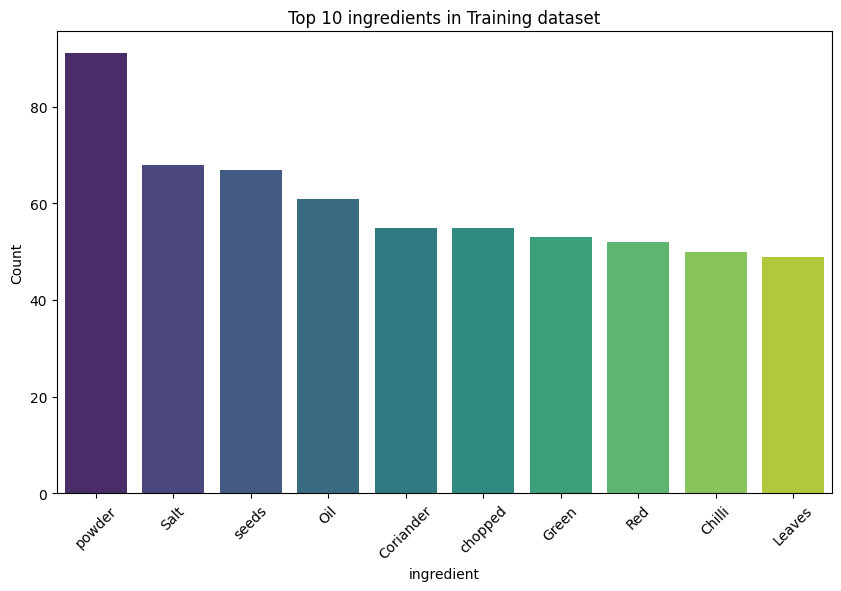

In [90]:
# plot the top frequent ingredients in training data
plotTopItems(topIngredients, 'ingredient', 'Training')

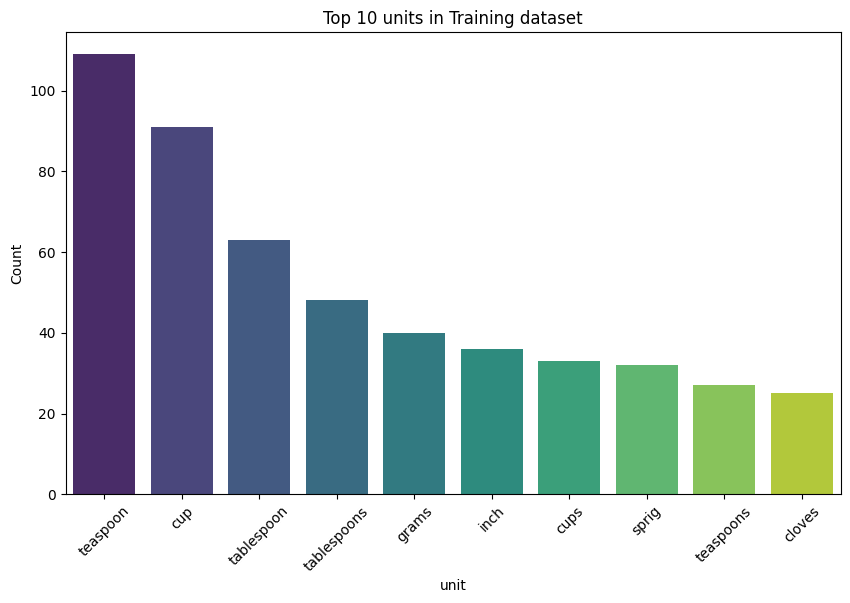

In [91]:
# plot the top frequent units in training data
plotTopItems(topUnits, 'unit', 'Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name


In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [ ]:
# plot the top frequent ingredients in validation data


In [ ]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [93]:
# define unit and quantity keywords along with quantity pattern
unitKeywords = set(units)
quantityKeywords = set(quantities)
quantityPattern = re.compile(r"""
                            \d+                      # Matches whole numbers (e.g., '1')
                            (\s\d+/\d+)?             # Matches fractions preceded by a space (e.g., '1 1/2')
                            (\.\d+)?                 # Matches decimal numbers (e.g., '1.5')
                            |                        # OR
                            \d+\s?[\u00BC-\u00BE\u2150-\u215E] # Matches Unicode fractions
                             """
                            , re.VERBOSE)

In [94]:
# load spaCy model
spacyModel = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [117]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
# Process the entire sentence with spaCy

def word2features(sent, i):
    token = sent[i]
    doc = spacyModel(token)
    token = doc[0]  # Get the first token from the processed document

    # --- Core Features ---
    features = {
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'is_digit': token.text.isdigit(),
        'is_alpha': token.text.isalpha(),
        'is_stop': token.is_stop,
        'is_punct': token.is_punct,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.text.istitle(),
        'is_upper': token.text.isupper(),
        'shape': token.shape_,
        'prefix': token.prefix_,
        'suffix': token.suffix_,
        'length': len(token.text),
        'bias': 1.0
    }
    # --- Improved Quantity & Unit Detection ---
    tokenLowerCase = token.text.lower()
    features['is_quantity'] = any(keyword in tokenLowerCase for keyword in quantityKeywords)
    features['is_unit'] = any(keyword in tokenLowerCase for keyword in unitKeywords)
    features['is_numeric'] = tokenLowerCase.replace('.', '', 1).isdigit()  
    features['is_fraction'] = bool(re.fullmatch(r"\d+\s?[\u00BC-\u00BE\u2150-\u215E]", tokenLowerCase))
    features['preceeding_word'] = sent[i-1] if i > 0 else ''
    features['following_word'] = sent[i+1] if i < len(sent) - 1 else ''

    # --- Contextual Features ---
    if i > 0:
        prev_token = sent[i-1].lower()
        features['prev_token'] = prev_token
        features['prev_is_quantity'] = (bool(quantityPattern.fullmatch(prev_token)) or prev_token in quantityKeywords)
        features['prev_is_digit'] = prev_token.isdigit()
    else:
        features['BOS'] = True
    
    if i < len(sent) - 1:
        next_token = sent[i+1].lower()
        features['next_token'] = next_token
        features['next_is_digit'] = next_token.isdigit()
        features['next_is_unit'] = (next_token in unitKeywords)
        features['next_is_ingredient'] = not(next_token in unitKeywords or next_token in quantityKeywords)
    else:
        features['EOS'] = True
    
    return features


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [108]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2Features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [118]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
XTrainFeatures = [sent2Features(sent) for sent in XTrain]
XValFeatures = [sent2Features(sent) for sent in XVal]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [119]:
# Convert labels into list as y_train_labels and y_val_labels
yTrainLabels = [list(map(str, sent)) for sent in yTrain]
yValLabels = [list(map(str, sent)) for sent in yVal]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [120]:
# print the length of train features and labels
print("Training Features and Labels Lengths:")
print("XTrainFeatures:", len(XTrainFeatures))
print("yTrainLabels:", len(yTrainLabels))

Training Features and Labels Lengths:
XTrainFeatures: 142
yTrainLabels: 142


In [121]:
# print the length of validation features and labels
print("Validation Features and Labels Lengths:")
print("XValFeatures:", len(XValFeatures))
print("yValLabels:", len(yValLabels))

Validation Features and Labels Lengths:
XValFeatures: 62
yValLabels: 62


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [123]:
# Flatten labels in y_train
yTrainFlat = flattenList(yTrain.values)
yTrainFlat

['quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'quantity',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'ingredient',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'quantity',
 'ingredient',
 'quantity',
 'unit',
 'ingredient',
 'ingredient',
 'unit',
 'ingredient',
 'ingredient'

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [124]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
labelCounts = Counter(yTrainFlat)
totalSamples = sum(labelCounts.values())
totalSamples

4632

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [126]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weightDict = {label: totalSamples / count for label, count in labelCounts.items()}

In [128]:
weightDict

{'quantity': 7.03951367781155,
 'unit': 8.227353463587923,
 'ingredient': 0.6789797713280563}

In [127]:
# penalise ingredient label
weightDict['ingredient'] = weightDict['ingredient'] / 2

In [171]:
weightDict

{'quantity': 7.03951367781155,
 'unit': 8.227353463587923,
 'ingredient': 0.6789797713280563}

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [140]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extractFeaturesWithClassWeights(X, y, weightDict):
    XFeatures = []
    yLabels = []
    scaledFeatures = []

    for sent, labels in zip(X, y):
        features = sent2Features(sent)

        for i, feature in enumerate(features):
            label = labels[i]
            weight = weightDict.get(label, 1.0)
            scaledFeature = feature.copy()

            for k, v in scaledFeature.items():
                if isinstance(v, (int, float)):
                    scaledFeature[k] = v * weight
            scaledFeatures.append(scaledFeature)
        XFeatures.append(scaledFeatures)
        yLabels.append(labels)
        scaledFeatures = []
    return XFeatures, yLabels


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [141]:
# Apply manually computed class weights
XTrainWeightedFeatures, yTrainLabels = extractFeaturesWithClassWeights(XTrain, yTrain, weightDict)
XValWeightedFeatures, yValLabels = extractFeaturesWithClassWeights(XVal, yVal, weightDict)

In [142]:
# Shape of the training and validation features
print("Training and Validation Features Shapes:")
print("XTrainWeightedFeatures:", len(XTrainWeightedFeatures))
print("XValWeightedFeatures:", len(XValWeightedFeatures))
print("yTrainLabels:", len(yTrainLabels))
print("yValLabels:", len(yValLabels))

Training and Validation Features Shapes:
XTrainWeightedFeatures: 142
XValWeightedFeatures: 62
yTrainLabels: 142
yValLabels: 62


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [143]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crfModel = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
    )
# train the CRF model with the weighted training data
crfModel.fit(XTrainWeightedFeatures, yTrainLabels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [144]:
# evaluate on the training dataset
yTrainPred = crfModel.predict(XTrainWeightedFeatures)

In [156]:
# specify the flat classification report by using training data for evaluation
yTrainTrueFlat = [label for sent in yTrainLabels for label in sent]
yTrainPredFlat = [label for sent in yTrainPred for label in sent]
labels = list(set(yTrainTrueFlat))
print(classification_report(yTrainTrueFlat, yTrainPredFlat))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      3411
    quantity       1.00      1.00      1.00       658
        unit       0.99      1.00      1.00       563

    accuracy                           1.00      4632
   macro avg       1.00      1.00      1.00      4632
weighted avg       1.00      1.00      1.00      4632



In [172]:
# create a confusion matrix on training datset
labels = list(set(yTrainTrueFlat))
confusionMatrixTrain = confusion_matrix(yTrainTrueFlat, yTrainPredFlat, labels=labels)

print("Confusion Matrix:")
print("Labels", labels)
print(confusionMatrixTrain)

Confusion Matrix:
Labels ['unit', 'ingredient', 'quantity']
[[ 562    0    1]
 [   0 3411    0]
 [   3    0  655]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [151]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crfModel, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [158]:
# predict the crf model on validation dataset
yValPred = crfModel.predict(XValWeightedFeatures)

In [159]:
# specify flat classification report
yValTrueFlat = [label for sent in yValLabels for label in sent]
yValPredFlat = [label for sent in yValPred for label in sent]
print(classification_report(yValTrueFlat, yValPredFlat))

              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      1611
    quantity       1.00      0.99      1.00       294
        unit       0.99      1.00      1.00       244

    accuracy                           1.00      2149
   macro avg       1.00      1.00      1.00      2149
weighted avg       1.00      1.00      1.00      2149



In [173]:
# create a confusion matrix on validation dataset
labels = list(set(yValTrueFlat))
confusionMatrixVal = confusion_matrix(yValTrueFlat, yValPredFlat, labels=labels)
print("Confusion Matrix:")
print("Labels", labels)
print(confusionMatrixVal)

Confusion Matrix:
Labels ['unit', 'ingredient', 'quantity']
[[ 244    0    0]
 [   0 1611    0]
 [   2    0  292]]


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [162]:
# flatten Labels and Initialise Error Data
yValTrueFlat = [label for sent in yValLabels for label in sent]
yValPredFlat = [label for sent in yValPred for label in sent]
valTokensFlat = [token for sent in XVal for token in sent]
errorData = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [165]:
# iterate and collect Error Information
XValList = list(XVal)
yValLabelsList = list(yValLabels)
yValPredList = list(yValPred)

for sentIndex in range(len(XValList)):
    tokens = XValList[sentIndex]
    trueLabels = yValLabelsList[sentIndex]
    predLabels = yValPredList[sentIndex]
    
    for i in range(len(tokens)):
        trueLabel = trueLabels[i]
        predLabel = predLabels[i]

        if trueLabel != predLabel:
            token = tokens[i]
            prevToken = tokens[i - 1] if i > 0 else '<START>'
            nextToken = tokens[i + 1] if i < len(tokens) - 1 else '<END>'

            classWeight = weightDict.get(trueLabel, 1.0)
            
            errorData.append({
                'token': token,
                'true_label': trueLabel,
                'predicted_label': predLabel,
                'prev_token': prevToken,
                'next_token': nextToken,
                'class_weight': classWeight
            })

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [167]:
# Create DataFrame and Print Overall Accuracy
errorDF = pd.DataFrame(errorData)

totalPredictions = sum(len(sent) for sent in yValLabels)
totalErrors = len(errorDF)

overallAccuracy = (totalPredictions - totalErrors) / totalPredictions * 100
overallAccuracy


99.90693345742206

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [170]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

labelErrorCounts = Counter(errorDF['true_label'])

for label, count in labelErrorCounts.items():
    weight = weightDict.get(label, 1.0)
    print(f"Label: {label}, ErrorCount: {count}, Class Weight: {weight:.4f}")

# Display the error DataFrame
print("Error DataFrame:")
print(errorDF)

Label: quantity, ErrorCount: 2, Class Weight: 7.0395
Error DataFrame:
    token true_label predicted_label prev_token next_token  class_weight
0  little   quantity            unit     leaves       Salt      7.039514
1   taste   quantity            unit        per        1/2      7.039514


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

**Insights**
- Tokens little & taste were incorrectly predicted as unit instead of quantity even though they are classified accurately in majority of the cases. Suggests that model has some ambiguities with the prediction.
- Class weights helped in balancing the contribution of the labels. Penalising the ingredient has helped in reducing the errors.
- The tokens that were misclassified did not have clear contextual markers such as previous or next words which provide clear context.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

- Model shows strong performance in recognising recipe entities.
- Model Accuracy is very high on both Training & Test data sets
- Recommend this model to be tested on other real world practical data.